In [10]:
import sys

sys.path.append("../libs")


CONFIG = {
    "model_path": "../data/model/model_calibrated.joblib",
    "features_path": "../data/model/baseline_features_list.json",
    "baseline_params": {
        "iterations": 1000,
        "depth": 12,
        "l2_leaf_reg": 6.746177457576027,
        "bagging_temperature": 0.8742701385986703,
        "random_strength": 1.396267713352505e-06,
        "colsample_bylevel": 0.9806866307913759,
        "subsample": 0.8259950282990149,
        "auto_class_weights": "SqrtBalanced",
        "learning_rate": 0.03666539436503066,
    },
        "features_to_remove": [
            'loan_status', 'int_rate', 'debt_settlement_flag',
               "last_pymnt_d",
    "last_pymnt_amnt",
    "recoveries",
    "collection_recovery_fee",
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "funded_amnt_inv",
    #"int_rate",
    "acc_now_delinq",
    "grade", "sub_grade",
    "delinq_amnt"]

}

In [11]:
import pandas as pd

df = pd.read_parquet('../data/lending_club_case_train_dataset.parquet')
df_test = pd.read_parquet('../data/lending_club_case_case_test_dataset.parquet')

In [20]:
import json
import joblib

model = joblib.load(CONFIG["model_path"])

with open(CONFIG["features_path"], 'r') as f:
    features = json.load(f)

cat_features = [
        "emp_length",
        "home_ownership",
        "verification_status",
        "purpose",
        "addr_state",
        "application_type",
    ]

In [13]:
def processing(df):
    cat_features = [
        "emp_length",
        "home_ownership",
        "verification_status",
        "purpose",
        "addr_state",
        "application_type",
    ]
    df['time_of_banking_days'] = (df['issue_d'] - df['earliest_cr_line']).dt.days
    df['time_of_banking_months'] = (df['issue_d'].dt.year - df['earliest_cr_line'].dt.year) * 12 + (df['issue_d'].dt.month - df['earliest_cr_line'].dt.month)

    df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

    df = df.drop(columns=CONFIG['features_to_remove'])

    df[cat_features] = df[cat_features].astype(str).fillna('missing')

    return df


In [14]:
df_test = processing(df_test)
df = processing(df)

In [16]:
df = df[features + ["default"]]

In [17]:
df_test = df_test[features  + ["id"]]


In [ ]:
df_test

In [51]:
df = df[features + ["default"]]
df[cat_features] = df[cat_features].astype(str).fillna('missing')

df_test = df_test[features]
df_test[cat_features] = df_test[cat_features].astype(str).fillna('missing')


In [18]:
X_train = df.drop(columns=["default"])
y_train = df["default"]


In [19]:
X_train

,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,...,sec_app_collections_12_mths_ex_med,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,time_of_banking_days,time_of_banking_months
0,5000,36,162.87500,10+ years,RENT,24000.0,Verified,credit_card,AZ,27.656250,...,-1,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,9830.0,323.0
1,2500,60,59.84375,< 1 year,RENT,30000.0,Source Verified,car,GA,1.000000,...,-1,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,4627.0,152.0
2,2400,36,84.31250,10+ years,RENT,12252.0,Not Verified,small_business,IL,8.718750,...,-1,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,3682.0,121.0
3,10000,36,339.25000,10+ years,RENT,49200.0,Source Verified,other,CA,20.000000,...,-1,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,5782.0,190.0
4,3000,60,67.81250,1 year,RENT,80000.0,Source Verified,other,OR,17.937500,...,-1,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,5813.0,191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925487,24000,60,690.50000,< 1 year,RENT,107000.0,Source Verified,other,CO,11.648438,...,-1,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,8036.0,264.0
2925488,10000,36,313.25000,10+ years,MORTGAGE,65000.0,Source Verified,debt_consolidation,PA,19.546875,...,-1,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,8613.0,283.0
2925489,10050,36,358.25000,8 years,RENT,37000.0,Not Verified,debt_consolidation,VA,20.562500,...,-1,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,8736.0,287.0
2925490,6000,36,197.75000,5 years,RENT,41000.0,Source Verified,credit_card,NY,19.984375,...,-1,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,9832.0,323.0


In [21]:
from catboost import CatBoostClassifier


baseline_params = CONFIG['baseline_params']
baseline_params['cat_features'] = cat_features
model = CatBoostClassifier(**baseline_params)

print('Traning the model...')
model.fit(X_train, y_train,)

Traning the model...
0:	learn: 0.6526530	total: 1.13s	remaining: 18m 53s
1:	learn: 0.6165469	total: 1.86s	remaining: 15m 30s
2:	learn: 0.5845296	total: 2.62s	remaining: 14m 29s
3:	learn: 0.5562605	total: 3.52s	remaining: 14m 37s
4:	learn: 0.5309910	total: 4.41s	remaining: 14m 37s
5:	learn: 0.5074704	total: 5.29s	remaining: 14m 35s
6:	learn: 0.4862697	total: 6.01s	remaining: 14m 12s
7:	learn: 0.4668828	total: 6.7s	remaining: 13m 50s
8:	learn: 0.4504073	total: 7.59s	remaining: 13m 56s
9:	learn: 0.4347921	total: 8.47s	remaining: 13m 58s
10:	learn: 0.4217399	total: 9.37s	remaining: 14m 2s
11:	learn: 0.4104133	total: 10.2s	remaining: 14m 2s
12:	learn: 0.3999556	total: 11.1s	remaining: 14m 6s
13:	learn: 0.3904476	total: 12s	remaining: 14m 7s
14:	learn: 0.3816767	total: 13s	remaining: 14m 12s
15:	learn: 0.3741638	total: 13.7s	remaining: 14m 4s
16:	learn: 0.3672930	total: 14.5s	remaining: 13m 55s
17:	learn: 0.3612182	total: 15.4s	remaining: 13m 59s
18:	learn: 0.3552960	total: 16.1s	remaining: 

In [28]:
X = df_test.drop(columns=["id"])

In [29]:
df_test["id"]

472065     130607974
472066     130932509
472071     130910225
472078     130942737
472079     130951046
             ...    
1082964    145319173
1082965    145307484
1082977    144957684
1082979    145177297
1082980    145190854
Name: id, Length: 208329, dtype: Int64

In [30]:
df_test["probabilities"] = model.predict_proba(X)[:, 1]

In [33]:
df_test[["id", "probabilities"]].to_parquet("../data/qfriends.parquet")

<Axes: >

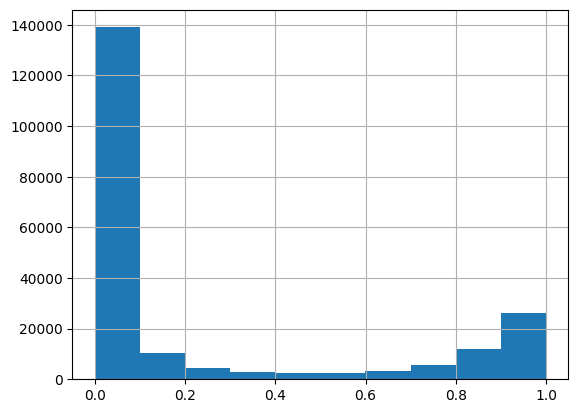

In [35]:
df_test["probabilities"].hist()